# LDA in PySparks MLlib

**Linear Discriminant Analysis**, otherwise known as *Topic Modeling*, is an unsupervised machine learning method for discovering topics by reducing dimension space. This method is very popular with Natural Language Processing (NLP) where the intent of the analysis is to discover themes or tags in a dataset that contains natural written language like tweets, news paper articles or even recipes! 

Today we will be analyzing a collection of christmas cooking recipes scraped from BBC Good Food. Let's see if we can try to discover some additional themes amongst these recipes imagining that we want to create our own website that provides a more intelligent tagging system to recipes that are pulled from multiple data sources.

**Approach** <br>
There are several ways to tackle Topic Modeling out there today so I thought I would spend today introducing you to one of the most popular and traditional approaches just get you comfortable with the concept. The coding leading up to where we pass our data into the LDA algorithm will look much like what we covered in the NLP series where we first cleaned our data, then tokenize the data, remove stopwords, and then create a count vector. Then the next step of our analysis will start to look more like the approach we took in the k-means lecture where we will need to find the "optimal k" which in this case we can think of more lore like topics instead of clusters. Then the fun part starts where we can see that kinds of topics our model came up with!

So let's dig in and see what it finds!

In [1]:
# First let's create our PySpark instance
# import findspark
# findspark.init()

import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

# May take awhile locally
spark = SparkSession.builder.appName("LDA").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
appid = spark._jsc.sc().applicationId()
print("You are working with", cores, "core(s) on appid: ", appid)
spark

22/10/13 02:08:10 WARN Utils: Your hostname, masoud-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.7.139 instead (on interface wlp2s0)
22/10/13 02:08:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/13 02:08:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/13 02:08:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
You are working with 1 core(s) on appid:  local-1665614292731


In [2]:
# Read in dependencies
# import string
from pyspark.sql.types import IntegerType, StringType, FloatType, DoubleType, ArrayType
from pyspark.ml.feature import (
    MinMaxScaler,
    RegexTokenizer,
    StopWordsRemover,
    CountVectorizer,
    Word2Vec,
)
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import (
    col,
    avg,
    min,
    lower,
    regexp_replace,
    udf,
    array_max,
)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# For pipeline development in case you need it (but we won't use it here)
from pyspark.ml import Pipeline

## Dataset

This JSON lines file contains 1600 christmas cooking recipes scraped from BBC Good Food.

### Content

 - Recipe Title
 - Recipe Description (we are going to focus on this variable for our analysis)
 - Recipe Author
 - Ingredients list
 - Step by step method

**Source:** https://www.yanlong.app/gjbroughton/christmas-recipes



**Read in the data**

In [3]:
path = "Datasets/"
df = spark.read.json(path + "recipes.json")

**View data as always**

In [4]:
df.limit(5).toPandas()

,Author,Description,Ingredients,Method,Name,url
0,Mary Cadogan,Combine a few key Christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...
1,Mary Cadogan,An easy-to-make alternative to traditional Chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...
2,Sara Buenfeld,These beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...
3,Paul Hollywood,Paul Hollywood's fruit rolls can be made ahead...,"[500g strong white flour, plus extra for dusti...",[Put the flour and 1 tsp salt into a large bow...,Christmas buns,https://www.bbcgoodfood.com/recipes/1803633/ch...
4,Barney Desmazery,"Made these for the second time today, and I ha...","[280g self-raising flour, 175g golden caster s...",[Heat oven to 190C/170 fan/gas 5 and line a 12...,Christmas cupcakes,https://www.bbcgoodfood.com/recipes/981634/chr...


**And of course the schema**

In [5]:
df.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Ingredients: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Method: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Name: string (nullable = true)
 |-- url: string (nullable = true)



## Investigate missing values

In [6]:
def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if nullRows > 0:
            temp = k, nullRows, (nullRows / numRows) * 100
            null_columns_counts.append(temp)
    return null_columns_counts


null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(
    null_columns_calc_list, ["Column_Name", "Null_Values_Count", "Null_Value_Percent"]
).show()

+-----------+-----------------+------------------+
|Column_Name|Null_Values_Count|Null_Value_Percent|
+-----------+-----------------+------------------+
|     Author|                6|0.3710575139146568|
|Description|              188|11.626468769325912|
+-----------+-----------------+------------------+



## Drop missing values

Since we are focusing on the description variable for our analysis today, I'm just going to drop the rows that have missing values in that column. 

In [7]:
# drop missing values for the sake of the example
df = df.na.drop(subset=["Description"])
df.count()

1429

## Prep the data (the NLP part)

This will include the following steps:

 - Clean text
 - Tokenize
 - Remove Stopwords
 - Create Count Vector of your words (features)


In [8]:
# Let's see a few full rows for the description column
df.select("Description").show(2, False)

+------------------------------------------------------------------------------------------------+
|Description                                                                                     |
+------------------------------------------------------------------------------------------------+
|Combine a few key Christmas flavours here to make a pie that both children and adults will adore|
|An easy-to-make alternative to traditional Christmas cakes which requires no beating            |
+------------------------------------------------------------------------------------------------+
only showing top 2 rows



Looks like pretty standard text with punctuation, camel casing and hyphenated words. We can use a pretty simple approach for this using two of the regex replace methods we saw in the NLP lecture and the lower method which lower cases all the text. 

In [9]:
############## Clean text ##############

# Removing anything that is not a letter
df_clean = df.withColumn(
    "Description", lower(regexp_replace(col("Description"), "[^A-Za-z ]+", " "))
)
# Remove multiple spaces (because we replaced punctuation with a space)
df_clean = df_clean.withColumn(
    "Description", regexp_replace(col("Description"), " +", " ")
)
df_clean.select("Description").show(2, False)

+------------------------------------------------------------------------------------------------+
|Description                                                                                     |
+------------------------------------------------------------------------------------------------+
|combine a few key christmas flavours here to make a pie that both children and adults will adore|
|an easy to make alternative to traditional christmas cakes which requires no beating            |
+------------------------------------------------------------------------------------------------+
only showing top 2 rows



**Tokenize, remove stopwords and create a count vector**

We will use a pipeline for this. 

In [10]:
# Tokenize
regex_tokenizer = RegexTokenizer(
    inputCol="Description", outputCol="words", pattern="\\W"
)
raw_words = regex_tokenizer.transform(df_clean)

# Remove Stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(raw_words)

cv = CountVectorizer(inputCol="filtered", outputCol="features")
cvmodel = cv.fit(words_df)
df_vect = cvmodel.transform(words_df)

In [11]:
# View the new dataframe
df_vect.limit(2).toPandas()

,Author,Description,Ingredients,Method,Name,url,words,filtered,features
0,Mary Cadogan,combine a few key christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...,"[combine, a, few, key, christmas, flavours, he...","[combine, key, christmas, flavours, make, pie,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Mary Cadogan,an easy to make alternative to traditional chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...,"[an, easy, to, make, alternative, to, traditio...","[easy, make, alternative, traditional, christm...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


## Determine Optimal K for LDA

This portion is going to be more like our k-means analysis where we plot our results and look for the elbow except this time we will be using the following metrics (the only ones PySpark provides):

**Log likelihood:** Calculates a lower bound on the log likelihood of the entire corpus. We want higher numbers here. See Equation (16) in the Online LDA paper (Hoffman et al., 2010).

**Log Perplexity:** Calculate an upper bound on perplexity. See Equation (16) in the Online LDA paper (Hoffman et al., 2010). We want lower numbers here, however keep in mind that this evaluation metric is debatable as many have shown that, surprisingly, perplexity and human judgment are often not correlated, and even sometimes slightly anti-correlated. Here is one interesting paper here on the subject: http://qpleple.com/perplexity-to-evaluate-topic-models/

22/10/13 02:08:25 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/13 02:08:25 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Text(0, 0.5, 'lp')

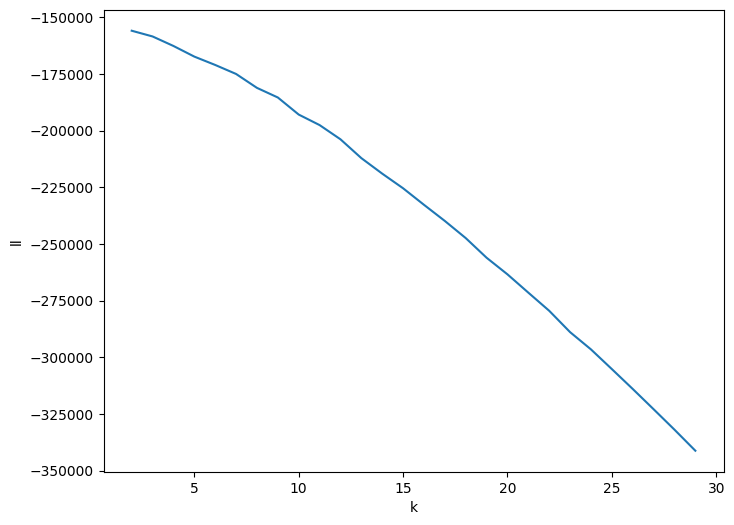

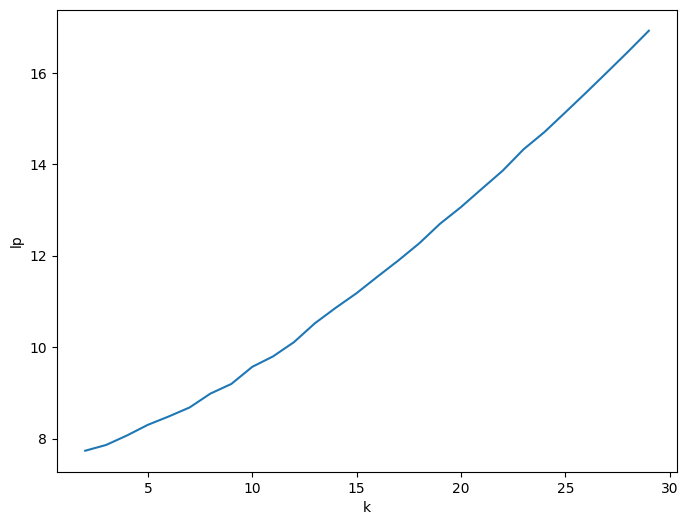

In [12]:
kmax = 30
ll = np.zeros(kmax)
lp = np.zeros(kmax)
for k in range(2, kmax):
    lda = LDA(k=k, maxIter=10)
    model = lda.fit(df_vect)
    ll[k] = model.logLikelihood(df_vect)
    lp[k] = model.logPerplexity(df_vect)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, kmax), ll[2:kmax])
ax.set_xlabel("k")
ax.set_ylabel("ll")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, kmax), lp[2:kmax])
ax.set_xlabel("k")
ax.set_ylabel("lp")

### Conclusions from graph output obove
Looks like in both cases (ll and lp) our model gets worse as k increases. So let's go with a low number of k. I'm going to go with 4 for the purpose of demonstration but we might want to play around with this a bit in a real analysis.


## Train your Final LDA Model using preferred K

In [13]:
# Trains a LDA model.
lda = LDA(k=4, maxIter=10)
model = lda.fit(df_vect)

Here is where things get fun!

In [14]:
print("Recap of ll and lp:")
ll = model.logLikelihood(df_vect)
lp = model.logPerplexity(df_vect)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))
print("Vocab Size: ", model.vocabSize())

# Describe topics.
print("The topics described by their top-weighted terms:")
topics = model.describeTopics(maxTermsPerTopic=5)
# topics.show(truncate=False)
topics = topics.collect()
vocablist = cvmodel.vocabulary
# Enumerate adds a counter to topics and returns it in a form of enumerate object.
for x, topic in enumerate(topics):
    print(" ")
    print("TOPIC: " + str(x))
    # This is like a temp holder
    topic = topics
    # Then we extract the words from the topics
    words = topic[x][1]
    weights = topic[x][2]
    # Then print the words by topics
    for n in range(len(words)):
        print(vocablist[words[n]] + " " + str(np.round(weights[n], 3)))

Recap of ll and lp:


The lower bound on the log likelihood of the entire corpus: -162686.95802877666
The upper bound on perplexity: 8.066588557555368
Vocab Size:  3476
The topics described by their top-weighted terms:
 
TOPIC: 0
dish 0.001
indulgent 0.001
makes 0.001
filo 0.001
pastry 0.001
 
TOPIC: 1
christmas 0.007
make 0.005
really 0.004
party 0.004
made 0.004
 
TOPIC: 2
christmas 0.009
make 0.008
recipe 0.008
made 0.005
like 0.005
 
TOPIC: 3
festive 0.003
meal 0.002
christmas 0.002
simple 0.002
classic 0.002


Cool! Looks like there are some relativley interesting topics but not super clear. From here we would need to create our own naming convention for each topic, like for example, topic 2 might be "Traditional Chocolate Cake Recipes". Or you could add tags to the recipes. Now let's see if we can recommend a topic for each row in the dataframe.


## Recommend a Topic for each row

In [23]:
# Make predictions
transformed = model.transform(df_vect)


# Convert topicdistribution col from vector to array
# We need to create a udf for this one
# to_array = udf(lambda x: x.toArray().tolist(), ArrayType(DoubleType()))
# recommendations = transformed.withColumn("array", to_array("topicDistribution"))

# # Find the best topic value that we will call "max"
# max_vals = recommendations.withColumn("max", array_max("array"))

# # Find the index of the max value found above which translates to our topic!
# argmaxUdf = udf(lambda x, y: [i for i, e in enumerate(x) if e == y])
# results = max_vals.withColumn("topic", argmaxUdf(max_vals["array"], max_vals["max"]))

max_index = udf(lambda x: x.tolist().index(max(x)), IntegerType())
results = transformed.withColumn("topicID", max_index("topicDistribution"))
results.printSchema()
results.limit(10).toPandas()

root
 |-- Author: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Ingredients: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Method: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Name: string (nullable = true)
 |-- url: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)
 |-- topicID: integer (nullable = true)



,Author,Description,Ingredients,Method,Name,url,words,filtered,features,topicDistribution,topicID
0,Mary Cadogan,combine a few key christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...,"[combine, a, few, key, christmas, flavours, he...","[combine, key, christmas, flavours, make, pie,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02049651750453438, 0.02431336204599207, 0.9...",2
1,Mary Cadogan,an easy to make alternative to traditional chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...,"[an, easy, to, make, alternative, to, traditio...","[easy, make, alternative, traditional, christm...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.02280308454300211, 0.027234824658309828, 0....",2
2,Sara Buenfeld,these beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...,"[these, beautiful, and, classy, little, cakes,...","[beautiful, classy, little, cakes, make, lovel...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01853564618160716, 0.02222910187032948, 0.9...",2
3,Paul Hollywood,paul hollywood s fruit rolls can be made ahead...,"[500g strong white flour, plus extra for dusti...",[Put the flour and 1 tsp salt into a large bow...,Christmas buns,https://www.bbcgoodfood.com/recipes/1803633/ch...,"[paul, hollywood, s, fruit, rolls, can, be, ma...","[paul, hollywood, fruit, rolls, made, ahead, h...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.015742215945646728, 0.018796159669613458, 0...",2
4,Barney Desmazery,made these for the second time today and i hav...,"[280g self-raising flour, 175g golden caster s...",[Heat oven to 190C/170 fan/gas 5 and line a 12...,Christmas cupcakes,https://www.bbcgoodfood.com/recipes/981634/chr...,"[made, these, for, the, second, time, today, a...","[made, second, time, today, say, turned, great...","(1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, ...","[0.009208230744743513, 0.0109527987039113, 0.9...",2
5,Good Food,a nutty winter salad which is superhealthy qui...,"[2 carrots, halved, ½ white cabbage, shredded,...",[Peel strips from the carrots using a vegetabl...,Christmas slaw,https://www.bbcgoodfood.com/recipes/890635/chr...,"[a, nutty, winter, salad, which, is, superheal...","[nutty, winter, salad, superhealthy, quick, pr...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.016963777923234072, 0.9394782643190203, 0.0...",1
6,Caroline Hire,delicious and a synch to make have made this a...,"[600ml double cream, 400g Greek yoghurt, 4 tbs...",[In a small saucepan gently heat the frozen be...,Christmas mess,https://www.bbcgoodfood.com/recipes/2806664/ch...,"[delicious, and, a, synch, to, make, have, mad...","[delicious, synch, make, made, couple, times, ...","(0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, ...","[0.005546646858933777, 0.006743405606077416, 0...",2
7,Miriam Nice,can i made these the day before,"[200g unsalted buttercut into cubes, plus extr...",[Grease and line a 20cm x 20cm brownie tin. He...,Christmas brownies,https://www.bbcgoodfood.com/recipes/christmas-...,"[can, i, made, these, the, day, before]","[made, day]","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0689713134630643, 0.08596341135321717, 0.77...",2
8,Good Food,how many servings have you gotten using the ab...,"[500ml vodka, 500ml gingerwine, 1l cranberry j...",[Mix the vodka and ginger wine in a jug. Stir ...,Christmas cosmopolitan,https://www.bbcgoodfood.com/recipes/889643/chr...,"[how, many, servings, have, you, gotten, using...","[many, servings, gotten, using, measures]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0342056334

## Next Steps

Awesome! Now that we have our data in a manageable form, we could use this to autocategorize recipes in a new recipe site we create into meaningful tabs like "chocolate" or "baking". We could also just auto-tag any recipes that are uploaded by users too which would also users to search our database more easily. How cool would that be?! It might also be cool look at the most common topics by Author or common ingredient.